# Decision Trees
Problem : **Titanic Survior** Prediction Kaggle Challenge

## Learning Goals
- How to pre-process data?
    - Dropping not useful features
    - Filling the missing values (Data Imputation)
- Creating a Binary Decision Tree from Scratch

In [1]:
import numpy as np
import pandas as pd

In [2]:
data  = pd.read_csv("../Datasets/Titanic/titanic.csv")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
columns_to_drop = ["PassengerId", "Name", "Ticket", "Cabin", "Embarked"]
data_clean = data.drop(columns_to_drop, axis=1)
data_clean.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500


In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data_clean["Sex"] = le.fit_transform(data_clean["Sex"])
data_clean.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,1,22.0,1,0,7.2500
1,1,1,0,38.0,1,0,71.2833
2,1,3,0,26.0,0,0,7.9250
3,1,1,0,35.0,1,0,53.1000
4,0,3,1,35.0,0,0,8.0500


In [6]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null int64
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
dtypes: float64(2), int64(5)
memory usage: 48.8 KB


In [8]:
# can be done using sklearn->impute
data_clean = data_clean.fillna(data_clean["Age"].mean())

In [9]:
data_clean.loc[1]

Survived     1.0000
Pclass       1.0000
Sex          0.0000
Age         38.0000
SibSp        1.0000
Parch        0.0000
Fare        71.2833
Name: 1, dtype: float64

In [12]:
input_cols = ["Pclass","Sex","Age","SibSp","Parch","Fare"]
output_cols = ["Survived"]

X = data_clean[input_cols]
Y = data_clean[output_cols]

print(X.shape, Y.shape)
print(type (X) )

(891, 6) (891, 1)
<class 'pandas.core.frame.DataFrame'>


In [13]:
def entropy(col):
    
    counts = np.unique(col, return_counts=True)
    N = col.shape[0]
    
    ent = 0
    
    for ix in counts[1]:
        p = ix/N
        ent -= p*np.log2(p)
        
    return ent

In [19]:
def divide_data(x_data, fKey, fVal):
    # Work with pandas data frames
    x_left = pd.DataFrame([], columns=x_data.columns)
    x_right = pd.DataFrame([], columns=x_data.columns)
    
    for i in range(x_data.shape[0]):
        val = x_data[fKey].loc[i]
        if val > fVal:
            x_right = x_right.append(x_data.loc[i])
        else:
            x_left = x_left.append(x_data.loc[i])
    return x_left, x_right

In [33]:
def info_gain(x_data, fKey, fVal):
    left, right = divide_data(x_data, fKey, fVal)
    # % of samples on left and right
    l = left.shape[0]/x_data.shape[0]
    r = right.shape[0]/x_data.shape[0]
    
    # All examples on one side
    if left.shape[0]==0 or right.shape[0]==0:
        return -1000000  #Min information gain
    
    i_gain = entropy(x_data.Survived) - (l*entropy(left.Survived) + r*entropy(right.Survived))
    return i_gain

In [34]:
# Testing
for fx in X.columns:
    print(fx)
    print(info_gain(data_clean, fx, data_clean[fx].mean()))

Pclass
0.0757936274361
Sex
0.217660106661
Age
0.000883615122947
SibSp
0.0095845418134
Parch
0.0153807544931
Fare
0.042140692839


In [39]:
class DecisionTree:
    
    def __init__(self, depth=0, maxDepth=5):
        self.left = None
        self.right = None
        self.fKey = None
        self.fVal = None
        self.maxDepth = maxDepth
        self.depth = depth
        self.target = None
        
    def train(self, x_train):
        
        features = ["Pclass","Sex","Age","SibSp","Parch","Fare"]
        info_gains = []
        
        for ix in features:
            i_gain = info_gain(x_train, ix, x_train[ix].mean())
            info_gains.append(i_gain)
            
        self.fKey = features[np.argmax(info_gains)]
        self.fVal = x_train[self.fKey].mean()
        print("Feature",self.fKey)
        
        # Split data
        data_left, data_right = divide_data(x_train, self.fKey, self.fVal)
        # Make indexing start from 0 in both arrays
        data_left = data_left.reset_index(drop=True)
        data_right = data_right.reset_index(drop=True)
        
        # Set targets for all nodes (not just leaves)
        if x_train.Survived.mean() >= 0.5:
            self.target = "Survive"
        else:
            self.target = "Dead"
            
        # Truly leaf or maxDepth reached (base case)
        if data_left.shape[0] == 0 or data_right.shape[0] == 0 or self.depth >= self.maxDepth:
            return
        
        # Recurse
        self.left = DecisionTree(depth=self.depth+1, maxDepth=self.maxDepth)
        self.left.train(data_left)
        
        self.right = DecisionTree(depth=self.depth+1, maxDepth=self.maxDepth)
        self.right.train(data_right)
    
    def predict(self, test):
        if test[self.fKey] > self.fVal :
            if self.right is None:
                return self.target
            return self.right.predict(test)
        else:
            if self.left is None:
                return self.target
            return self.left.predict(test)

## Train-Validation-Test Set Split
Validation -> Tune hyperparams

In [40]:
split = int(0.7*data_clean.shape[0])
train_data = data_clean[:split]
test_data = data_clean[split:]
test_data = test_data.reset_index(drop=True)

In [41]:
print(train_data.shape, test_data.shape)

(623, 7) (268, 7)


In [73]:
dt = DecisionTree()
dt.train(train_data)

Feature Sex
Feature Pclass
Feature Age
Feature SibSp
Feature Pclass
Feature Age
Feature Age
Feature SibSp
Feature Parch
Feature Pclass
Feature SibSp
Feature Fare
Feature Parch
Feature Age
Feature Pclass
Feature Age
Feature Age
Feature Parch
Feature SibSp
Feature Fare
Feature Age
Feature Age
Feature Fare
Feature Age
Feature Age
Feature Fare
Feature Age
Feature Parch
Feature Fare
Feature Fare
Feature Fare
Feature Age
Feature Fare
Feature Parch
Feature Fare
Feature Age
Feature Age
Feature Fare
Feature Fare
Feature SibSp
Feature Fare
Feature Age
Feature Fare
Feature Pclass
Feature SibSp
Feature Age
Feature Age
Feature Age
Feature Pclass
Feature Age
Feature SibSp
Feature Fare
Feature SibSp
Feature Age
Feature Parch
Feature SibSp
Feature SibSp
Feature Age
Feature Age
Feature Age
Feature Parch
Feature Age
Feature Age


In [74]:
y_pred = []
for i in range(test_data.shape[0]):
    y_pred.append(dt.predict(test_data[input_cols].loc[i]))
le = LabelEncoder()
y_pred = le.fit_transform(y_pred)
print(np.unique(y_pred,return_counts=True))

(array([0, 1]), array([193,  75]))


In [75]:
y_test_actual = Y[split:] 

In [76]:
print(np.unique(y_test_actual,return_counts=True))

(array([0, 1]), array([172,  96]))


In [77]:
y_pred = np.array(y_pred).reshape((-1,1))
acc = np.sum(y_pred==y_test_actual)/y_pred.shape[0]
print(acc)

Survived    0.817164
dtype: float64


## Decision Tree using SkLearn

In [78]:
from sklearn.tree import DecisionTreeClassifier

In [79]:
sk_tree = DecisionTreeClassifier(criterion='entropy', max_depth=5)
sk_tree.fit(train_data[input_cols], train_data[output_cols])

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [80]:
print(sk_tree.predict(test_data[input_cols]))

[0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0
 1 0 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 1 1 1 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 1 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0
 0 1 0 1 0 0 1 0 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0 0 1
 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 1 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 1 0 0 1 1 1 1 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 1 1 0 0 0 1 0 0
 1 0 0 0 0 1 1 0 0]


In [81]:
sk_tree.score(test_data[input_cols], test_data[output_cols])

0.82835820895522383

## Visualize a Decision Tree

In [82]:
import pydotplus

from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz

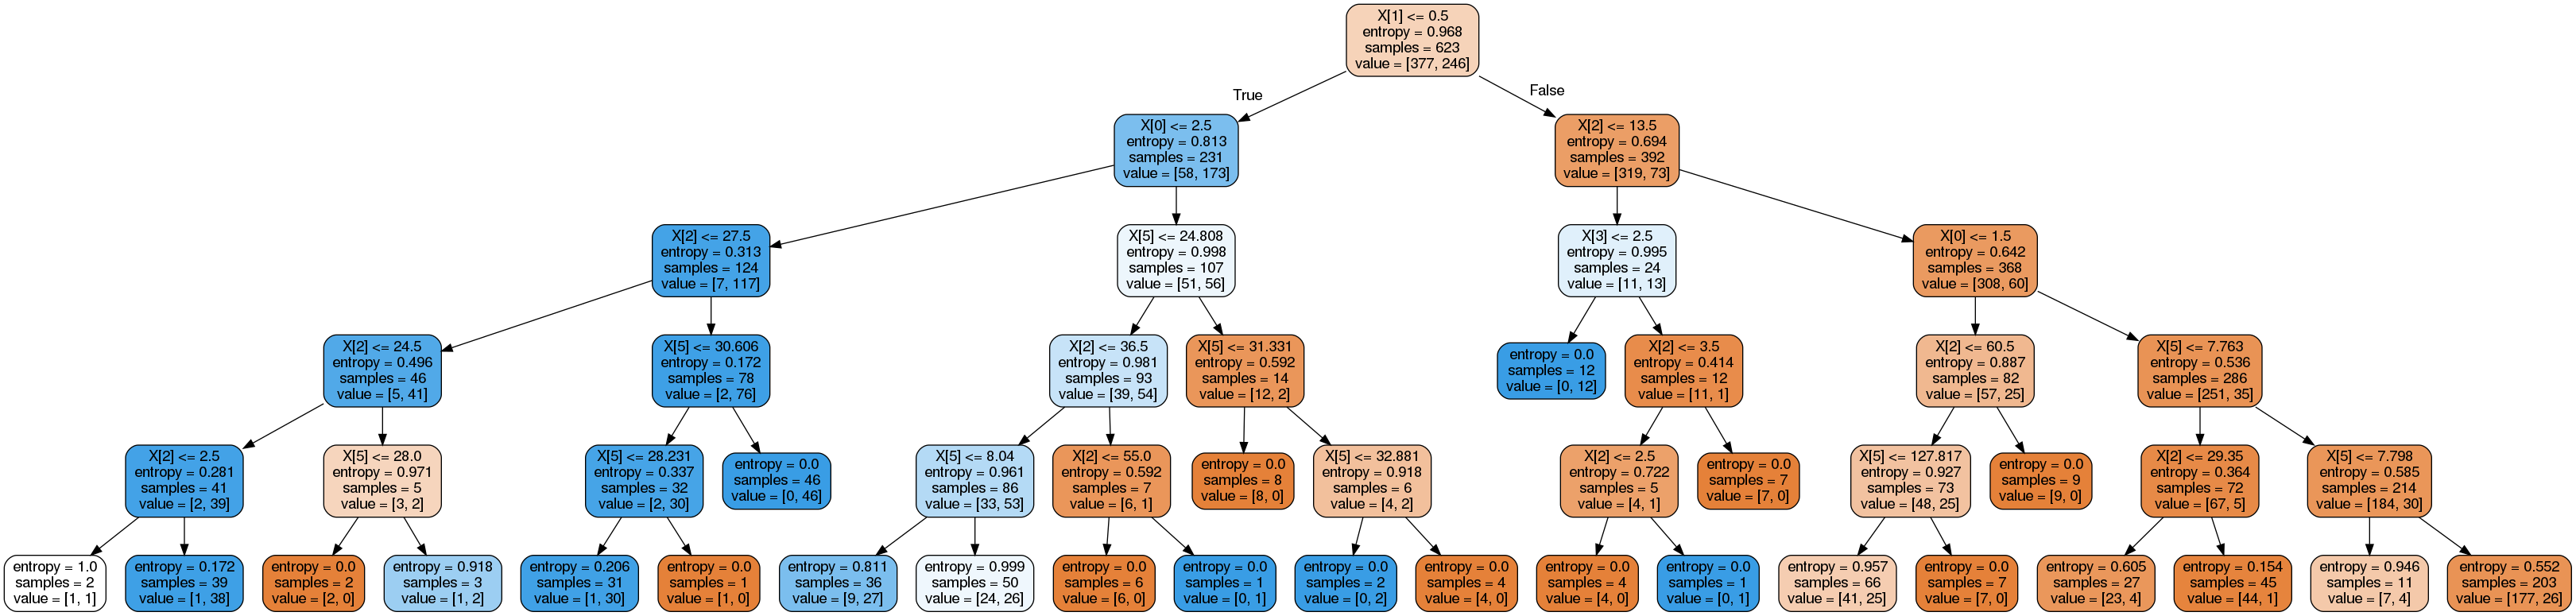

In [83]:
dot_data = StringIO()
export_graphviz(sk_tree, out_file=dot_data, filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

## Random Forest

In [84]:
x_train = train_data[input_cols]
y_train = np.array(train_data[output_cols]).reshape((-1,))
x_test = test_data[input_cols]
y_test = np.array(test_data[output_cols]).reshape((-1,))

In [86]:
# For no max depth specified
sk_tree = DecisionTreeClassifier(criterion='entropy')
sk_tree.fit(x_train, y_train)
sk_tree.score(x_train, y_train)

0.9823434991974318

In [87]:
# It overfits, performs poorly on test set
sk_tree.score(x_test, y_test)

0.77985074626865669

In [88]:
from sklearn.ensemble import RandomForestClassifier

In [90]:
rf = RandomForestClassifier(n_estimators=10, criterion='entropy', max_depth=5)
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [91]:
rf.score(x_train, y_train)

0.85874799357945431

In [92]:
rf.score(x_test, y_test)

0.80597014925373134

In [93]:
from sklearn.model_selection import cross_val_score

In [100]:
acc_list = []
for i in range(1,50):
    rf = RandomForestClassifier(n_estimators=i, max_depth=5)
    rf.fit(x_train, y_train)
    acc = cross_val_score(rf, x_train, y_train, cv=5).mean()
    acc_list.append(acc)
print(acc_list)

[0.74156722990271373, 0.79301341525857649, 0.78021239119303643, 0.78826420890937021, 0.79949062980030716, 0.79795473630312341, 0.82187875064004101, 0.7978515104966718, 0.80115432667690722, 0.80742693292370704, 0.81075473630312334, 0.83000757808499748, 0.79795412186379922, 0.82189165386584739, 0.80270312339989758, 0.79950332821300563, 0.8011035330261137, 0.80903963133640544, 0.80759324116743481, 0.8155037378392217, 0.80422672811059903, 0.82193015873015862, 0.82345314900153621, 0.81072933947772652, 0.80743922171018956, 0.80754183307731675, 0.81224024577572962, 0.8042394265232975, 0.81390394265232968, 0.82510455709165387, 0.81235514592933955, 0.81229103942652325, 0.81711664106502813, 0.80910373783922174, 0.81541423451100881, 0.82035535074244748, 0.80594162826420901, 0.81390394265232968, 0.81396784434203773, 0.82506625704045056, 0.81561925243215561, 0.82191746031746038, 0.81381423451100865, 0.82191705069124432, 0.81871664106502817, 0.81706543778801832, 0.81386543778801834, 0.81230373783922

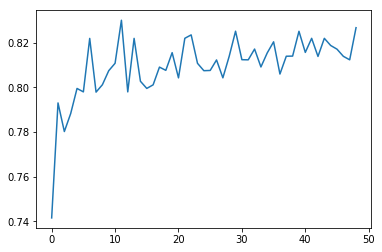

In [101]:
import matplotlib.pyplot as plt
plt.plot(acc_list)
plt.show()

In [102]:
print(np.argmax(acc_list))

11


In [103]:
rf = RandomForestClassifier(n_estimators=11, max_depth=5)
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=11, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [104]:
rf.score(x_train, y_train)

0.8459069020866774

In [105]:
rf.score(x_test, y_test)

0.82089552238805974